# Feed-forward and Recurrent Language Models

### Preliminaries

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# !pip install jsonlines tqdm

In [3]:
# download pretrained models and data
### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('personachat_all_sentences_train.jsonl'):
    !wget "https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl" -O 'personachat_all_sentences_train.jsonl'
if not os.path.exists('personachat_all_sentences_valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/8krcizo8sms1m0ppy7uiwfcx4a3l5nsq.jsonl" -O 'personachat_all_sentences_valid.jsonl'
if not os.path.exists('personachat_all_sentences_test.jsonl'):
    !wget "https://nyu.box.com/shared/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl" -O 'personachat_all_sentences_test.jsonl'

## wikitext-2 dataset
if not os.path.exists('wikitext2-sentencized.json'):
    !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O 'wikitext2-sentencized.json'

### pretrained ffnn model
if not os.path.exists('personachat_ffnn_lm.pt'):
    !wget "https://nyu.box.com/shared/static/looczvct7ssh30x0gwqmvencple8xok9.pt" -O 'personachat_ffnn_lm.pt'

### pretrained rnn model
if not os.path.exists('personachat_rnn_lm.pt'):
    !wget "https://nyu.box.com/shared/static/3jl9erctnvbefnczgmetkdil0xwpcxzb.pt" -O 'personachat_rnn_lm.pt'

## N-gram modeling as classification

In the previous n-gram language models lab, the probability of a word given a history ('prefix') was computed using n-gram **counts**.

In this lab, our goal will be the same: modeling the probability of variable length sequences, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{<t}),$$

by assuming that each word $x_t$ only depends on the preceding $n-1$ words, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{t-n+1},\ldots,x_{t-1}).$$


However, _instead of counts_, we will now use a **neural network** to **classify** each history, where each class is the next word.

<img src="img/fflm.png" alt="Drawing" style="width: 35%;"/>

[Diagram: modified from the [NLP Lecture Note](https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf) by Kyunghyun Cho]

## Modeling chat utterances

We will build a **feed-forward neural n-gram model** to model chat utterances.

### 1. Prepare the data

To load and preprocess the data, we'll use utility functions from `data.py`.

In [4]:
import data as data_utils

In [5]:
datasets = data_utils.load_personachat('./')
dictionary = data_utils.Dictionary(datasets, include_valid=True)

100%|██████████| 16181/16181 [00:03<00:00, 4182.78it/s]


Let's look at an example from the dataset (note that in addition to `train` we also have `valid`, `test` splits):

In [6]:
index = 0
split = 'train'
encoded = dictionary.encode_token_seq(datasets[split][index])
decoded = dictionary.decode_idx_seq(encoded)

print("Dataset size %d (train), %d (valid), %d (test).\n" %
     (len(datasets['train']), 
      len(datasets['valid']), 
      len(datasets['test'])))
print(' '.join(datasets[split][index]))
print(f'\n word indices - {encoded}')
print(f'\n words - {decoded}')

Dataset size 133176 (train), 16181 (valid), 15608 (test).

i am doing great except for the allergies .

 word indices - [4, 5, 6, 7, 8, 9, 10, 11, 12]

 words - ['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.']


Now we add `<bos>`, `<eos>`, and turn each **sequence** into **n-grams**:

In [7]:
ngram_order = 5
tokenized_datasets = data_utils.tokenize_dataset(
    datasets, dictionary, ngram_order
)
ngram_datasets = data_utils.slice_into_ngrams(
    tokenized_datasets, ngram_order
)

for i in range(10):
    decoded = dictionary.decode_idx_seq(ngram_datasets[split][index+i])
    print(f'\n {i} - {decoded}')


 0 - ['<bos>', '<bos>', '<bos>', '<bos>', 'i']

 1 - ['<bos>', '<bos>', '<bos>', 'i', 'am']

 2 - ['<bos>', '<bos>', 'i', 'am', 'doing']

 3 - ['<bos>', 'i', 'am', 'doing', 'great']

 4 - ['i', 'am', 'doing', 'great', 'except']

 5 - ['am', 'doing', 'great', 'except', 'for']

 6 - ['doing', 'great', 'except', 'for', 'the']

 7 - ['great', 'except', 'for', 'the', 'allergies']

 8 - ['except', 'for', 'the', 'allergies', '.']

 9 - ['for', 'the', 'allergies', '.', '<eos>']


Finally, we create a **Pytorch** `Dataset` and `DataLoader` that can be used for training a neural network.

In [8]:
from torch.utils.data import DataLoader

datasets = {}
dataloaders = {}
for split, dataset in ngram_datasets.items():
    dataset_ = data_utils.NgramDataset(dataset)
    datasets[split] = dataset_
    dataloaders[split] = DataLoader(
        dataset_, 
        batch_size=2048, 
        shuffle=(split == 'train'), 
        collate_fn=data_utils.batchify
    )

### 2. Defining the model


#### How do we represent the input $x_t$? 

Each $x_t$ is an **integer** (token id), and we transform it into a **vector** $f_{\text{embed}}(x_t)\in\mathbb{R}^d$ using an `Embedding` layer.

An embedding layer serves as a differentiable look-up table. Given an integer token id, it returns a vector representation which we call an **embedding**.

In [9]:
import torch
from torch.nn import Embedding
# Embedding??

In [10]:
lookup = Embedding(
    num_embeddings=len(dictionary), 
    embedding_dim=16, 
    padding_idx=dictionary.get_id('<pad>')
)

In [11]:
lookup.weight.size()

torch.Size([20089, 16])

In [12]:
input_ = dictionary.encode_token_seq(['hello', 'world'])
print(f'token ids: {[input_]}')

input_embedded = lookup(torch.tensor([input_], dtype=torch.long))
print(f'tokens embedding size: {input_embedded.size()}')

print("embedding for 'hello' (179):")
input_embedded[0, 0].data

token ids: [[179, 373]]
tokens embedding size: torch.Size([1, 2, 16])
embedding for 'hello' (179):


tensor([ 0.2058, -1.4078, -1.6780,  0.5725,  1.2602,  1.7072, -0.0795, -1.0495,
        -1.5490, -1.5199,  0.2801, -0.6290,  0.5157, -1.3839,  1.2235, -1.1600])

### Defining the neural network

There are three components:
1. `Embedding` $$\large f_{embed}:\text{vocab}\rightarrow \mathbb{R}^d$$
2. Hidden layer $$\large f_{hidden}: \mathbb{R}^{nd}\rightarrow \mathbb{R}^h$$
3. Projection $$\large f_{project}: \mathbb{R}^{h}\rightarrow \mathbb{R}^{|vocab|}$$

The conditional distribution is then: $$\large p(x_t|x_{t-1},\ldots,x_{t-n-1})=\text{softmax}(f_{project}(f_{hidden}(f_{embed}(x_{t-1},\ldots,x_{t-n-1}))).$$


We implement the hidden layer and projection with Pytorch `nn.Linear` layers:

In [13]:
import torch
import torch.nn as nn

class NeuralNgramLM(nn.Module):
    def __init__(self, options):
        super().__init__()
        self.lookup = nn.Embedding(
            num_embeddings=options['num_embeddings'], 
            embedding_dim=options['embedding_dim']
        )
        self.hidden_layer = nn.Linear(
            options['input_size'], 
            options['hidden_size'], 
            bias=True
        )
        self.projection = nn.Linear(
            options['hidden_size'], 
            options['num_embeddings']
        )

    def forward(self, inp):
        embedded = self.lookup(inp)
        embedded_timeflat = embedded.view(embedded.size(0), -1)
        hidden_out = self.hidden_layer(embedded_timeflat)
        hidden_out = torch.tanh(hidden_out)
        logits = self.projection(hidden_out)
        return logits

### 3. Train the model

#### Initialize the model, criterion (loss), and optimizer

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

load_pretrained = True

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_ffnn_lm.pt'):
        raise EOFError('No model downloaded!')
    model_dict = torch.load(
        'personachat_ffnn_lm.pt',
        map_location=torch.device(current_device)
    )
    
    options = model_dict['options']
    model = NeuralNgramLM(options).to(current_device)
    model.load_state_dict(
        model_dict['model_dict']
    )
    
else:
    embedding_size = 256
    ngram_order = 4
    input_size = embedding_size * ngram_order
    hidden_size = 512

    options = {
        'num_embeddings': len(persona_dict),
        'embedding_dim': embedding_size,
        'input_size': input_size,
        'hidden_size': hidden_size,
    }
    model = NeuralNgramLM(options).to(current_device)

criterion = nn.CrossEntropyLoss(
    ignore_index=dictionary.get_id('<pad>'), 
    reduction='sum'
)

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.01, momentum=0.99)

#### Training Loop

In [15]:
plot_cache = []

if not load_pretrained:
    for epoch_number in range(10):
        avg_loss = -1

        # -- Training
        model.train()

        train_loss_cache = 0
        train_non_pad_tokens_cache = 0

        # == Iterate through batches from the dataset.
        for i, (inp, target) in enumerate(dataloaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)

            # == Forward pass.
            logits = model(inp)

            # == Computed (summed) loss.
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()

            # == Compute the number of non `<pad>` tokens in the target.
            non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()

            # == Normalize the (summed) loss so that it is an average.
            loss /= non_pad_tokens  
            loss.backward()
            optimizer.step()

            train_non_pad_tokens_cache += non_pad_tokens
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))

        # -- Validation
        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0

        model.eval()
        with torch.no_grad():
            non_pad_tokens = 0
            for i, (inp, target) in enumerate(dataloaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)

                # == Forward pass and loss
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()            

                # == Normalize the loss
                non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()
                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

        plot_cache.append((avg_loss, avg_val_loss))

In [16]:
if load_pretrained:
    plot_cache = model_dict['loss_cache']

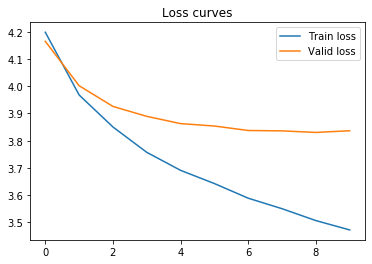

In [17]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

### 4. Evaluate the model

#### Recap: Perplexity
Recall **perplexity** from the preceding lab:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm. By default `torch.log` uses base `e`. 

To **convert to base 2** we use: `log_2 p = log_e p / log_e 2`.

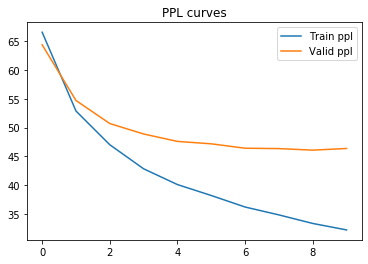

In [18]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [19]:
# Saving the model
if False:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, './persona_ffnn_lm.pt')

#### Conditional probability queries
We can now query the model for conditional probabilities:

\begin{align}
\large p(x_t|x_{t-1},\ldots,x_{t-4}) 
\end{align} 

In [20]:
import torch

def next_token_probabilities(prefix, token):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
    token_id = dictionary.get_id(token)
    p_next_token = torch.softmax(logits, dim=-1)
    return p_next_token[0, token_id]

prefix = '<bos> i have a'

for w in ['dog', 'zebra', 'donut', 'velociraptor']:
    prob = next_token_probabilities(prefix, w)
    print('p( %s  | %s )\t= %.3E' % (w, prefix, prob))
    

p( dog  | <bos> i have a )	= 7.468E-02
p( zebra  | <bos> i have a )	= 1.473E-04
p( donut  | <bos> i have a )	= 7.881E-06
p( velociraptor  | <bos> i have a )	= 1.323E-06




And sort by the highest probability next-tokens:

$\large \texttt{sort}(p(\cdot|\underbrace{x_{<t}}_{\text{prefix}}))$

In [21]:
def get_top_token_given_prefix(prefix, top=10):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
        
    p_next_token = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_token_ids = torch.topk(p_next_token[0], top)

    for i in range(sorted_token_ids.size(0)):
        print('p( %s  | %s )\t= %.5f' % 
              (dictionary.decode_idx_seq([sorted_token_ids[i]])[0], 
               prefix, 
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos> i have a')  # '<bos> the weather is'  '<bos> <bos> <bos> hello'

p( dog  | <bos> i have a )	= 0.07468
p( cat  | <bos> i have a )	= 0.04418
p( lot  | <bos> i have a )	= 0.04310
p( job  | <bos> i have a )	= 0.03759
p( couple  | <bos> i have a )	= 0.03458
p( few  | <bos> i have a )	= 0.02293
p( black  | <bos> i have a )	= 0.01704
p( little  | <bos> i have a )	= 0.01618
p( hard  | <bos> i have a )	= 0.01604
p( very  | <bos> i have a )	= 0.01478


# Recurrent neural network language model
Recall that in **language modeling**, we want to model the probability of variable length sequences, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{<t}).$$

*Unlike n-gram models*, we will now define a model that allows a **full history** $x_{<t}$.

To do so, we will use a function called a **recurrent neural network** to compute each distribution $p(x_t|x_{<t})$:
\begin{align}
h_t &= f^{\text{RNN}}_{\theta}(x_{t-1}, h_{t-1}) & \mathbb{R}^d\\
s_t &= Wh_t & \mathbb{R}^{\text{|vocab|}}\\
p_{\theta}(x_t|x_{<t}) &= \text{softmax}(s_t) & [0,1]^{\text{|vocab|}}
\end{align}

where $h_t$ is an internal (hidden) state of the model at time step $t$, and $x_t$ is an input at time step $t$.

<img src="img/rnn.png" alt="Drawing" style="width: 35%; margin-left: 29%; padding: 3em;"/>


In the simplest form used in practice, $f_{\theta}^{\text{RNN}}$ is defined as:
 $$f_{\theta}^{\text{RNN}}(x_{t-1}, h_{t-1}) = \text{tanh}(a_t)\\ a_t = b + W \cdot h_{t-1} + U \cdot x_{t-1},$$
 
but there are other variants (e.g. [GRU](https://arxiv.org/pdf/1406.1078.pdf), [LSTM](https://www.bioinf.jku.at/publications/older/2604.pdf)).

Similar to the n-gram neural network above, the goal at time $t$ is to **predict the next token $x_t$**.

### Pytorch implementation: `RNNCell`

In [22]:
from torch.nn import RNNCell
# RNNCell??

In [23]:
import torch
hidden_size = 16
embedding_dim = 8

rnn_cell = RNNCell(embedding_dim, hidden_size)

In [24]:
hidden = torch.zeros(1, hidden_size)
print(hidden)
print(hidden.size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([1, 16])


In [25]:
random_input = torch.rand(1, embedding_dim)
print(random_input)
print(random_input.size())

tensor([[0.0930, 0.4627, 0.9704, 0.8953, 0.9627, 0.6349, 0.5765, 0.1750]])
torch.Size([1, 8])


In [26]:
hidden = rnn_cell(random_input, hidden)
print(hidden)
print(hidden.size())

tensor([[ 0.3407, -0.4730,  0.2777,  0.3367,  0.1212, -0.0710,  0.5852, -0.2135,
          0.3524, -0.4331, -0.6299,  0.5394, -0.3666, -0.2773,  0.5754,  0.0126]],
       grad_fn=<TanhBackward>)
torch.Size([1, 16])


### Pytorch implementation: `RNN`

`RNNCell` is a building block of an RNN model. The Pytorch `RNN` model supports multi-layer networks by creating separate `RNNCell`s for every layer. 

`RNN` can also process a whole sequence of data by iteratively applying `RNNCell`.

In [27]:
from torch.nn import RNNBase, RNN
# RNNBase.__init__??
# RNN.__init__??

### 1. Define the model

In [28]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    def __init__(self, options):
        super().__init__()
        
        self.lookup = nn.Embedding(
            num_embeddings=options['num_embeddings'], 
            embedding_dim=options['embedding_dim'], 
            padding_idx=options['padding_idx']
        )
        self.rnn = nn.RNN(
            options['input_size'], 
            options['hidden_size'], 
            options['num_layers'], 
            dropout=options['rnn_dropout'], 
            batch_first=True
        )
        self.projection = nn.Linear(
            options['hidden_size'], 
            options['num_embeddings']
        )
        
    def forward(self, token_ids):
        embeddings = self.lookup(token_ids)
        output, hidden = self.rnn(embeddings)
        logits = self.projection(output) 
        return logits

### 2. Prepare the data

#### Dataset and Dataloader

See `data_utils.py` for the implementation. 

In [29]:
datasets_ = data_utils.load_personachat('./')
dictionary = data_utils.Dictionary(datasets_, include_valid=True)
datasets_ = data_utils.tokenize_dataset(datasets_, dictionary)

datasets = {}
for split, dataset in datasets_.items():
    datasets[split] = data_utils.TensoredDataset(dataset, dictionary.get_id('<pad>'))

100%|██████████| 16181/16181 [00:03<00:00, 4277.84it/s]


- The **input** is now a **full sequence**.
- The **output** is the **next token** for each position of the input:

In [30]:
inp, out = datasets['train'][0]

print("Input: \n\t%s\n\t(%s)" %
      (inp.data[0], dictionary.decode_idx_seq(inp.data[0])))

print("Output: \n\t%s\n\t(%s)" %
      (out.data[0], dictionary.decode_idx_seq(out.data[0])))

Input: 
	tensor([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12])
	(['<bos>', 'i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.'])
Output: 
	tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12,  1])
	(['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.', '<eos>'])


#### Pytorch dataloader

In [31]:
dataloaders = {}
batch_size = 128

for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=dataset.pad_collate_fn  # pads the sequences in the batch
    )

#### Padding to handle variable sequence lengths:

In [32]:
inp, target = next(dataloaders['train'].__iter__())

print("Batch size %s" % str(inp.shape))
print("Batch element 1: \n\t%s\n\t(%s)" %
      (inp.data[0], ' '.join(dictionary.decode_idx_seq(inp.data[0]))))
print("Batch element 2: \n\t%s\n\t(%s)" %
      (inp.data[1], ' '.join(dictionary.decode_idx_seq(inp.data[1]))))

Batch size torch.Size([128, 22])
Batch element 1: 
	tensor([    0,   726,    33, 11842,   400,    43,     4,  1903,   938,    33,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2])
	(<bos> hey ! jefferson here , i adore nickelback ! <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>)
Batch element 2: 
	tensor([   0,  379,   43, 1790,    9, 3822,   43,  199,   26,  452,  169,  685,
          24,   24,   24,    2,    2,    2,    2,    2,    2,    2])
	(<bos> wow , c for cow , would your dog be called ? ? ? <pad> <pad> <pad> <pad> <pad> <pad> <pad>)


### 3. Train the model

#### Initializing model, criterion, and optimizer (similar to the feedforward model)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

load_pretrained = True

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load(
        'personachat_rnn_lm.pt',
        map_location=torch.device(current_device)
    )
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': len(dictionary),
        'embedding_dim': embedding_size,
        'padding_idx': dictionary.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }
    model = RNNLanguageModel(options).to(current_device)
    

criterion = nn.CrossEntropyLoss(
    ignore_index=dictionary.get_id('<pad>'), 
    reduction='sum'
)

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [34]:
model

RNNLanguageModel(
  (lookup): Embedding(20089, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=20089, bias=True)
)

#### Training loop (same as the feedforward model)

In [35]:
plot_cache = []

if not load_pretrained:
    for epoch_number in range(100):
        avg_loss = 0
        model.train()

        train_loss_cache = 0
        train_non_pad_tokens_cache = 0

        for i, (inp, target) in enumerate(persona_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here

            non_pad_tokens = target.view(-1).ne(persona_dict.get_id('<pad>')).sum().item()            
            train_non_pad_tokens_cache += non_pad_tokens

            loss /= non_pad_tokens 

            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []

        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0

        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(persona_loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()  # still sum here
                non_pad_tokens = target.view(-1).ne(persona_dict.get_id('<pad>')).sum().item()

                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache

            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

        plot_cache.append((avg_loss, avg_val_loss))


In [36]:
if load_pretrained:
    plot_cache = model_dict['loss_cache']

### 4. Evaluation

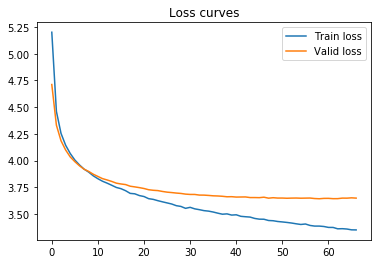

In [37]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

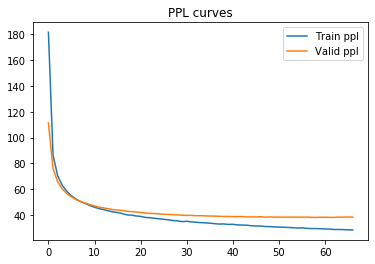

In [38]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

### Conditional probability queries

We can query different probabilities:

$\large p(\underbrace{x_t}_{\text{token}}|\underbrace{x_{<t}}_{\text{prefix}})$

In [39]:
import torch

def next_token_probabilities(prefix, token):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
        
    token_id = dictionary.get_id(token)
    p_next_token = torch.softmax(logits[0, -1], dim=-1)
    return p_next_token[token_id]

prefix = '<bos> i have a'

for w in ['dog', 'zebra', 'donut', 'velociraptor']:
    prob = next_token_probabilities(prefix, w)
    print('p( %s  | %s )\t= %.3E' % (w, prefix, prob))
    

p( dog  | <bos> i have a )	= 6.960E-02
p( zebra  | <bos> i have a )	= 1.633E-04
p( donut  | <bos> i have a )	= 1.039E-05
p( velociraptor  | <bos> i have a )	= 2.267E-07




And sort by the highest probability next-tokens:

$\large \texttt{sort}(p(\cdot|\underbrace{x_{<t}}_{\text{prefix}}))$

In [40]:
def get_top_token_given_prefix(prefix, top=10):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
        
    p_next_token = torch.softmax(logits[0, -1], dim=-1)
    sorted_probs, sorted_token_ids = torch.topk(p_next_token, top)

    for i in range(sorted_token_ids.size(0)):
        print('p( %s  | %s )\t= %.5f' % 
              (dictionary.decode_idx_seq([sorted_token_ids[i]])[0], 
               prefix, 
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos> the weather is')

p( great  | <bos> the weather is )	= 0.09953
p( nice  | <bos> the weather is )	= 0.07860
p( beautiful  | <bos> the weather is )	= 0.06185
p( fun  | <bos> the weather is )	= 0.05039
p( good  | <bos> the weather is )	= 0.04573
p( awesome  | <bos> the weather is )	= 0.04308
p( cool  | <bos> the weather is )	= 0.04212
p( my  | <bos> the weather is )	= 0.03604
p( a  | <bos> the weather is )	= 0.02892
p( so  | <bos> the weather is )	= 0.02230


### Generation (Sampling)

Finally, we can generate sentences using the model's conditional distribution:

            context = [<bos>]
            until <eos> is generated:
                wt ~ p(wt | context)
                context += [wt]
                
                
Here, the `~` symbol stands for sampling from a categorical distribution. 

In [41]:
import torch

def sample(model, prefix, num_samples, temperature=1.0, max_len=50):
    inp = torch.tensor([
        dictionary.encode_token_seq(prefix.split(' '))
    ], dtype=torch.long).to(current_device).repeat([num_samples, 1])

    sampled = [prefix.split(' ') for _ in range(num_samples)]
    done = torch.tensor([False for _ in range(num_samples)])
    hidden = None
    
    with torch.no_grad():
        model.eval()
        for t in range(max_len):
            logits, hidden = step(model, inp, hidden)
            logits_ = (logits[:, -1, :] / temperature)
            inp = logits_.softmax(-1).multinomial(1)            
            for i in range(num_samples):
                tok_ti = dictionary.get_token(inp[i, 0].item())
                if tok_ti == '<eos>' and not done[i]:
                    done[i] = True
                    sampled[i].append(tok_ti)
                elif not done[i]:
                    sampled[i].append(tok_ti)
                else:
                    pass
            if done.sum() == num_samples:
                break
        
    return sampled

def step(rnn, token_ids, hidden):
    embeddings = rnn.lookup(token_ids)
    output, hidden = rnn.rnn(embeddings, hidden)
    logits = rnn.projection(output) 
    return logits, hidden


prefix = '<bos> i have a'

for temp in [1.0, 0.5, 0.1]:
    print("Temperature %.2f" % temp)
    samples = sample(model, prefix, 5, temperature=temp)
    for s in samples:
        print(' '.join(s))
    print()

Temperature 1.00
<bos> i have a very shy character . <eos>
<bos> i have a girl for too . what do you do for a living ? <eos>
<bos> i have a cat named radar . he is a collie too . <eos>
<bos> i have a puppy year old son . now she does not let him go for vegan . <eos>
<bos> i have a punk mustang from a small town i have loved flowers . <eos>

Temperature 0.50
<bos> i have a cat . <eos>
<bos> i have a dog . he is a good voice . <eos>
<bos> i have a dog named that . <eos>
<bos> i have a lot of friends and family . <eos>
<bos> i have a dog . <eos>

Temperature 0.10
<bos> i have a lot of friends . <eos>
<bos> i have a dog named toto . <eos>
<bos> i have a dog named toto . <eos>
<bos> i have a dog named toto . <eos>
<bos> i have a dog named toto . <eos>



In [42]:
# Saving the model
if False:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, './static_files/persona_rnn_lm.pt')

## Large-scale Language Modeling: GPT-2

The language model above is relatively small in terms of the number of parameters, and is trained on a (very) small dataset.

Recently, researchers have trained **large-scale language models** on **large amounts of data**, resulting in improved language modeling and generation ability. 

A representative example is **GPT-2** [[paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)], [[blog](https://openai.com/blog/better-language-models/)]. We won't currently discuss the details of this model, but we can easily **use a pre-trained version to generate text**:

In [43]:
!pip install transformers

#### Load the model and tokenizer

In [44]:
import torch
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer
)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device);

#### Generate (Sampling)

We'll talk about other ways to generate later in the course.

In [45]:
prefix = 'My favorite food is'

max_length = 100
num_samples = 5

inp = torch.tensor([tokenizer.encode(prefix)], device=device).repeat(num_samples, 1)

out = model.generate(
    input_ids=inp,
    do_sample=True,
    max_length=max_length
)

for i in range(num_samples):
    sample = tokenizer.decode(out[i])
    print(sample)
    print('---------------------------------------------------')

My favorite food is not pizza…it is your meal!"

"Wanna try me out? I should really start by asking for a discount. It's awesome!"

"I'm here today with my buddy John to talk about this great recipe for Pizza Noodles."

Thank you so much for stopping by! We wanted to introduce you to John for lunch and dinner.

I like pizza. I've never had pizza in my life. The reason I have a
---------------------------------------------------
My favorite food is the prawns from the island of Tanga. It's very cheap and easy to get for the price of one and then again for the rice with the traditional pork chop and chicken prawns. And they also tend to be great with pork or pork ribs if you can find them locally, that's very special.

But how do you buy any special vegetables in Tonga?

The pinyon sauce in Tonga is made with a bamboo straw and
---------------------------------------------------
My favorite food is probably The Bistro, which is packed with the best, most savory food I've ever had. I love